# Spam Filtering

## Getting the Data

Usually getting good data is one of the hardest parts in a Data Science project.

For the next exercise we'll use simple dataset containing eml files (eml is the format in which emails are sent according [rfc 822](http://www.ietf.org/rfc/rfc0822.txt))

The emails were manually labeled into two categories: Spam and Non-Spam. We'll try to build a model (what is it?) which recognizes spam messages.

To proceed:

* Download trec emails dataset from https://plg.uwaterloo.ca/~gvcormac/treccorpus07/
* Extract the archive into **datasets/** directory

In [124]:
import os

assert os.path.isfile('datasets/trec07p/full/index'), "Please follow the instructions above"

In [125]:
#
# numpy is a library which allows manipulating arrays and matrices in Python in a similar way to Matlab.
#
import numpy as np
#
# Put random seed 0 to be consistent in the examples
#
np.random.seed(0)

#
# Read email files path and labels
#
with open('datasets/trec07p/full/index') as f:
    # index file contains one line per email with the following form: path ham/spam
    # (ham means non-spam)
    files = [line.strip().split() for line in f]
    ham = ['datasets/trec07p/full/' + path for cls, path in files if cls == 'ham']
    spam = ['datasets/trec07p/full/' + path for cls, path in files if cls == 'spam'][:len(ham)]
    
    # join ham and spam file paths and create labels vector
    emails = ham + spam
    
    # labels vector will contain 0 for ham messages and 1 for spam messages
    labels = np.zeros((len(emails),))
    labels[len(ham):] = 1

    # Shuffle the messages
    permutation = np.random.permutation(labels.size)
    emails = [emails[i] for i in permutation]
    labels = labels[permutation] > 0

Now we have preloaded our dataset and created two arrays of equal length:
* emails: the emails array contains paths to email messages
* labels: the labels array is binary array, where labels[i]=1 iff emails[i] is spam for i=0..len(emails)-1

## Study the Data on a Training Set

The learning procedure in machine learning is called training.

The training is usually done on a small subset of the real population: we try to build a program which classifies email messages. We use only ~50K messages in our dataset to build that program. The real population -- all email messages in the world -- is much bigger and there is no way that we can put our hands on it.

So how can we infer something about all emails in the world from just a tiny subset we use? That philosophical question might be less relevant for practical people than the following: how can we prove that we succeeded to learn something from the small training dataset.

We prove by saying to any skeptic: give us another tony subset of all the messages in the world, a subset that you care about, and we'll show that we are good at classifying your subset. We call this latter subset a test set.

So, when building machine learning programs we always have a training set with which we work and a test set that we never touch and use it just to see that the results are good.

In [126]:
#
# Split the data (the emails and the labels) into training and test sets
# in such way that training set contains 40000 emails and the test set the rest
#
train = emails[:40000]
test = emails[40000:]

y_train = labels[:40000]
y_test = labels[40000:]

In [127]:
assert len(train) == len(y_train) == 40000
assert len(test) == len(y_test) == len(emails) - 40000

The datasets we work with are often huge. However, in this exercice all the emails we have can fit into memory.

In [128]:
def read_file(path):
    with open(path, 'rb') as f:
        return f.read()

#
# Since we deal in this exercice with relatively small dataset, we can load everything into memory
#
train = [read_file(path) for path in train]
test = [read_file(path) for path in test]

## Classifying By Subject Length

Let's see if we can tell whether an email is a Spam by only looking on its length

In [129]:
def subject(content):
    """This function extracts the subject from an eml file"""
    
    # EML file begins with headers section which ends by two blank lines
    i = content.find(b'\n\n')
    if i < 0:
        return b''
    headers = content[:i]

    # One of the headers is the Email Subject
    subj = b'\nSubject:'
    j = headers.find(subj)
    if j < 0:
        return b''

    # Return the first line of the subject
    return headers[j+len(subj):].split(b'\n', maxsplit=1)[0].strip()

In [130]:
#
# Extract the subjects of all email messages in the training set
#
subjects = [subject(e) for e in train]

In [131]:
#
# Let's look at the data
#
goods = [s for s, y in zip(subjects, y_train) if not y] # Subjects of good emails
goods[:10]

[b'Rev 5353: forgot to check in privileges.h in',
 b'Re: [R] understanding round() behavior',
 b'[perl #43133] Re: GC bug on freebsd/x86, triggered by a perl6 test',
 b'UK bomb plotters are jailed',
 b'Re: Clickthrough for GPL',
 b'Re: [R] Opinion on R plots: connecting X and Y',
 b'Re: S12: can(), signatures and casting',
 b'Re: [ot] Windows programming',
 b'Re: lynx links and forms in speakup',
 b'Re: [R] Multiple trellis plots without intervening space']

In [132]:
bads = [s for s, y in zip(subjects, y_train) if  y] # Subjects of spam emails
bads[:10]

[b"You don't need perfect credit to apply for the imagine unsecured gold mastercard credit card",
 b'Mlcrosoft6,Adobea+M0RE starting at 26$',
 b'Avis Important et Personnel',
 b'Registry Cleaner: Scan the Windows registry (32-bit and 64-bit)',
 b'[1]: Improve your Odds',
 b'Avis Important et Personnel',
 b'Mesure importante de =?ISO-8859-1?Q?s=E9curit=E9?= provenant des',
 b'Avis Important et Personnel',
 b'Is discus an marital',
 b"She wants a better sex? All you need's here!"]

Create a numpy array length which contains the number of characters in every subject in the training set:

In [133]:
#
# Save the number of characters in every subject in an array named lengths
#
lengths = np.array([len(s) for s in subjects])

#
# Save the number of characters in every spam subject in an array named bad_lengths
#
bad_lengths = np.array([len(s) for s in bads])

#
# Save the number of characters in every non-spam subject in an array named good_lengths
#
good_lengths = np.array([len(s) for s in goods])

In [134]:
#
# The shape of a numpy n-dimensinal array is the dimensions. So for a 5x5, the shape would be (5, 5)
# and for a vector of length n, it would be (n,)
#
assert lengths.shape == (len(subjects),)

#
# A size of numpy vector is the number of its elements
#
assert bad_lengths.size == len(bads)
assert good_lengths.size == len(goods)

In [135]:
print('The mean of spam subject length is:', bad_lengths.mean())
print('The mean of non-spam subject length is:', good_lengths.mean())

The mean of spam subject length is: 30.897556344
The mean of non-spam subject length is: 41.162089149


## A Model

A model is an object which contains summary of the training data that allows us to do predictions on the test data.

In [136]:
#
# Create a simple model that classifies messages based on their subject length.
#
class Model:
    def train(self, bad_lengths, good_lengths):
        self._threshold = (bad_lengths.mean() + good_lengths.mean()) / 2
        return self
    
    def predict(self, message):
        """Tell if the message is spam or not"""
        
        subj = subject(message)
        length = len(subj)
        
        return length < self._threshold

class DecisionTree:
    def train(self, samples):
        ...
        
    def predict(self, samples):
        ...

In [137]:
#
# Create an instance of a model
#
model = Model().train(bad_lengths, good_lengths)

In [138]:
#
# Predict on some message if it is spam
#
model.predict(test[1]), y_test[1]

(False, False)

In [139]:
#
# Use the model to decide on all the messages in the test set whether they are spam
# 
y_pred = np.array([model.predict(message) for message in test])

In [140]:
#
# numpy arrays can be compared elementwise
#
correct_predictions = (y_pred == y_test)

#
# Calculate the prediction accuracy.
# 
print('Accuracy:', sum(correct_predictions) / len(correct_predictions))

Accuracy: 0.645977011494


The measure we calculated on our prediction is called accuracy. Accuracy is number of correct predictions divided by the total number of predictions.

We see that classifying by subject length is better than random. Please answer the following questions:
* What is the model we created?
* What is its training procedure?
* How did we test it?
* Can we do better? How?

## matplotlib

We'll answer the last question by steps. First, let's see if we can do better by using only subject lengths.

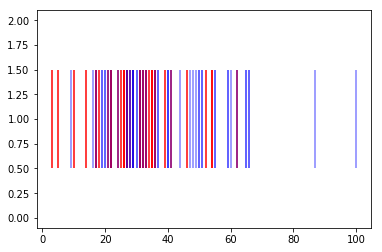

In [141]:
#
# matplotlib is a library which allows plotting in Python in a similar way to Matlab.
#
import matplotlib.pyplot as plt

# 
# Plot the lengths of 100 spam subjects in red
#
plt.eventplot(bad_lengths[50:100], colors='r')

# 
# Plot the lengths of 100 non-spam subjects in blue
#
plt.eventplot(good_lengths[50:100],  colors='b', alpha=0.5)

#
# Show the plots
#
plt.show()

So do you think we can use the lengths more cleverely then just thresholding by their averages?

## 1-D Decision Trees

In [142]:
#
# scikit-learn (sklearn) is a machine learning framework
# which implements most popular  machine learning algorithms (which do not involve neural networks),
# tools for preprocessing the data and for measuring the performance of these algorithms.
#
from sklearn.tree import DecisionTreeClassifier

In [143]:
#
# All scikit models implement the same interface...
#
tree = DecisionTreeClassifier()

#
# ...which contains a method fit(...) the performs the actual training.
#
tree.fit(lengths.reshape(-1, 1), y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [144]:
#
# ...and predict function which performs the inference
#
lengths_test = np.array([len(subject(message)) for message in test]).reshape(-1, 1)
y_pred = tree.predict(lengths_test)

In [145]:
correct_predictions = (y_pred == y_test)
print('Accuracy:', sum(correct_predictions) / len(correct_predictions))

Accuracy: 0.681992337165


In [146]:
#
# Accuracy, as well as other metrics can be calculated using sklearn
#
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.68199233716475094

## Adding More Dimensions

We call the input numbers that we pass to the model by the name features. In the previous example we used only one feature: length of the email subject. Can we add more features describing the subject to achieve higher accuracy?

In [147]:
def features(subj):
    """The function gets a subjects and outputs numeric features that describe it"""

    yield len(subj)
    yield subj.strip()[:1] == b'['
    
    #
    # TODO: add stuff here
    #

In [148]:
from collections import Counter
from scipy import stats

def entropy(bs):
    values = np.array(list(Counter(bs).values()))
    return stats.entropy(values / sum(values))

def subject_features(subj):
    """The function gets a subjects and outputs numeric features that describe it"""

    yield len(subj)
    yield subj.strip()[:1] == b'['
    
    #
    # TODO: add stuff here
    #
    yield sum([chr(c).islower() for c in subj])
    yield entropy(subj)
    yield subj[:4] == b'Re: '
    yield subj[:5] == b'Fwd: '
    yield b'$' in subj
    yield sum([chr(c).isdigit() for c in subj])
    yield sum([chr(c).isupper() for c in subj])

In [149]:
#
# Generate the features and store them in numpy arrays
#
X_train = np.array([list(subject_features(subject(message))) for message in train])
X_test = np.array([list(subject_features(subject(message))) for message in test])

In [150]:
#
# Train decision tree classifier and use it to do the prediction on a test set
#
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [151]:
#
# Check the accuracy of the predictions
#
y_pred = tree.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.927490421456


## Confusion Matrix

Accuracy is just one of many metrics used to measure model generative power: see [scikit metrics reference](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).

One useful model evaluation tool is the confusion matrix. To understand what we put in this matrix we use the following terminology: for a certain email message, if the model says that it is spam then we call it a positive. Otherwise, we say that it is negative.

* We say that a prediction is a false positive if the message is actually not a spam although the model said it is.
* We say that a prediction is a false negative if the message is actually a spam that the model didn't catch.

Confusion matrixis a table in which the counts of samples are written in the following way:

![ConfusionMatrix](https://www.dataschool.io/content/images/2015/01/confusion_matrix_simple2.png)

In [152]:
#
# Manually calculate the number of false positive and false negative predictions
# (notice how boolean operations can be called piecewise on boolean numpy arrays)
#
misclassified = (y_test != y_pred)
positive = (y_pred > 0)
negative = ~positive

sum_false_positives = sum(misclassified & positive)
sum_false_negatives = sum(misclassified & negative)

In [153]:
#
# Calculate the complete confusion matrix and put it in an array of shape 2x2 named cm
# 
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[4835,  396],
       [ 361, 4848]])

In [154]:
assert cm.shape == (2, 2)

assert cm[0, 1] == sum_false_positives
assert cm[1, 0] == sum_false_negatives

Use the following function to display a confusion matrix

In [155]:
import itertools

def plot_confusion_matrix(cm, classes=('Message', 'Spam'),
                          normalized=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """The function puts a plot of a confusion matrix"""
    if normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    if title:
        plt.title(title)

    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes)
    plt.yticks(ticks, classes)

    postfix = np.empty((len(classes), len(classes)), dtype=object)
    if normalized:
        postfix[:, :] = '%'
        postfix[0, -1] += ' (FPR)'
        postfix[-1, 0] += ' (FNR)'
    else:
        postfix[:, :] = ''
        postfix[0, -1] += ' (FP)'
        postfix[-1, 0] += ' (FN)'
    
    fmt = '.2f' if normalized else 'd'
    postifx = '%' if normalized else ''
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt) + postfix[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted', rotation=45)
    plt.ylabel('Actual', rotation=45)
    plt.show()

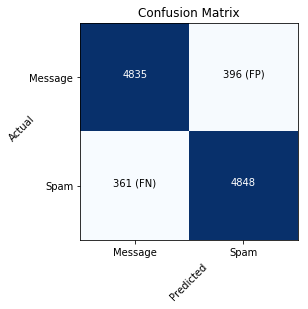

In [156]:
plot_confusion_matrix(cm)

Confusion matrix can be normalized by making the sum of values in each row to add up to 1:

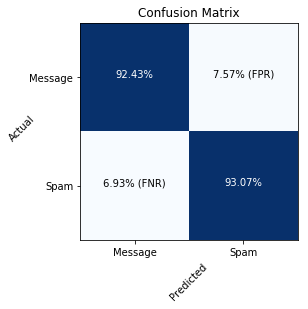

In [157]:
plot_confusion_matrix(cm, normalized=True)

## Adding More Features

We can look not only on email subject but on other things we see, like email sender or the whole contents.
Let's add more features that use more data from an email to get better results:

In [158]:
#
# Some helper function for parsing eml file
#
def get_headers(content):
    i = content.find(b'\n\n')
    if i < 0:
        return b''
    
    return content[:i]
    
def get_email_header(headers, header, default_value=b''):
    """Returns email sender"""
    
    name = b'\n' + header
    j = headers.find(name)
    if j < 0:
        return b''
    
    return headers[j+len(name):].split(b'\n', maxsplit=1)[0].strip()

def subject(headers):
    return get_email_header(headers, b'Subject', b'None')

def sender(headers):
    return get_email_header(headers, b'From', b'')

In [159]:
senders = [sender(get_headers(email)) for email in train]
senders[:10]

[b': Michael Adam <ma@sernet.de>',
 b': Goldstatus <Goldstatus@lanesdealer4u.com>',
 b': "Jagath Curran" <guenon@dudethink.com>',
 b': Groupe Desjardins / AccesD <services.de.cartes@scd.desjardins.com>',
 b': "jim holtman" <jholtman@gmail.com>',
 b': "Reginald" <adelle@optonline.net>',
 b': Joshua Isom (via RT) <parrotbug-followup@parrotcode.org>',
 b': Ainsely <viviangimrob@bayou.com>',
 b': Groupe Desjardins / AccesD <services.de.cartes@scd.desjardins.com>',
 b': BBC Breaking News Alert <dailyemail@ebs.bbc.co.uk>']

In [160]:
def features_ver1(content):
    headers = get_headers(content)

    subj = subject(headers)
    sender_domain = sender(headers)
    sender_domain = sender_domain.split(b'@')[-1][:-1] if sender_domain else b''
    
    yield from subject_features(subj)
    
    #
    # TODO: Add sender domain based features
    #
    yield sender_domain.endswith(b'.com')
    yield sender_domain.endswith(b'.org')

In [161]:
#
# Calculate the features
#
X_train = np.array([list(features_ver1(content)) for content in train])
X_test = np.array([list(features_ver1(content)) for content in test])

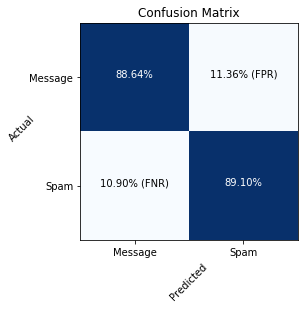

In [162]:
#
# Calculate the confusion matrix
#
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, normalized=True)

## Using Data Statistics for Prediction

In [163]:
#
# Look at the set of all domains from which an email was sent
#
senders = [sender(content) for content in train]
domains = [s.split(b'@')[-1][:-1] if (b'@' in s) else b'' for s in senders]

# Print 10 sample domains:
domains

[b'sernet.de',
 b'lanesdealer4u.com',
 b'dudethink.com',
 b'scd.desjardins.com',
 b'gmail.com',
 b'optonline.net',
 b'parrotcode.org',
 b'bayou.com',
 b'scd.desjardins.com',
 b'ebs.bbc.co.uk',
 b'',
 b'gmail.co',
 b'desjardins.com',
 b'lama.net.pl',
 b'math.unb.c',
 b'pellicano.biz',
 b'gmail.com',
 b'cm.nu',
 b'talkingirc.net',
 b'menne-biomed.de',
 b'scd.desjardins.com',
 b'fdp-bundestag.de',
 b'bitrixteam.com',
 b'proficio.ca',
 b'samba.org',
 b'imagin.net',
 b'verizon.com',
 b'scd.desjardins.com',
 b'paypal.com',
 b'samba.or',
 b'gmail.com',
 b'pelmorex.ca',
 b'cbsig.com',
 b'gmail.com',
 b'msn.com',
 b'rltconsulting.com',
 b'wanadoo.fr',
 b'hhu.umu.se',
 b'supplementcoach.com',
 b'howstuffworks.com',
 b'perlite.biz',
 b'gagliardi.name',
 b'playkids.com',
 b'mardel.pl',
 b'verizon.net',
 b'yahoo.com',
 b'speedy.uwaterloo.ca',
 b'aol.com',
 b'matchedamused.com',
 b'lottozubotto.com',
 b'samba.or',
 b'cbsig.com',
 b'astro.com.my',
 b'netzero.net',
 b'pelmorex.ca',
 b'winhostdir.com',

In [182]:
#
# Create a set off all domain from which a spam email was sent
#
good_domain = {domain for domain, y in zip(domains, y_train) if not y}
bad_domain = {domain for domain, y in zip(domains, y_train) if not y}

from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse=False)
vectorizer.fit([{'domain': domain.decode()} for domain in bad_domain])

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)

In [181]:
dom = list(bad_domain)[0].decode()
vectorizer.transform([{'domain': dom}])+

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.]])

In [165]:
good_domain

{b'',
 b'rz.rwth-aachen.de',
 b'robmyers.org',
 b'liv.ac.uk',
 b'ms.unimelb.edu.au',
 b'wcs.org',
 b'alphapoint05.net',
 b'gs.com',
 b'howstuffworks.com',
 b'blarg.net',
 b'scharp.org',
 b'organicconsumers.org',
 b'bio.uio.no',
 b'itc.nl',
 b'darmour.com',
 b'gaffa.vispa.com',
 b'rc.europe.yahoo-eu1.akadns.net',
 b'code.de',
 b'shibaya.lonestar.org',
 b'telbiomed.at',
 b'jtauber.com',
 b'creativecommons.org.au',
 b'ipimar.pt',
 b'quietstars.com',
 b'bank-banque-canada.ca',
 b'velocity-one.com',
 b'bccrc.ca',
 b'uta.fi',
 b'frontiernet.net',
 b'ceacs.march.es',
 b'ucsc.edu',
 b'TOURVILLES.COM',
 b'manchester.ac.uk',
 b'asheesh.org',
 b'stanford.edu',
 b'yhuk.com',
 b'exchange.lancs.ac.uk',
 b'univie.ac.at',
 b'CNNIMAIL23.CNN.COM',
 b'kleppe.net',
 b'nanonanonano.net',
 b'pa.net',
 b'telecomottawa.net',
 b'gregorycain.net',
 b'epfl.ch',
 b'uva.nl',
 b'keionline.or',
 b'jouy.inra.fr',
 b'douma.nl',
 b'kth.se',
 b'eurekaa.net',
 b'vr-networld.com',
 b'cathedrallabs.org',
 b'UQAR.QC.CA',
 b

In [166]:
def sender_domain_features(sender_domain):
    yield sender_domain.endswith(b'.org')
    yield sender_domain.endswith(b'.com')
    
    # NEW feature
    yield sender_domain in good_domain
    
def features_ver2(content):
    headers = get_headers(content)

    subj = subject(headers)
    send = sender(headers)
    sender_domain = send.split(b'@')[-1][:-1] if send else b''
    
    yield from subject_features(subj)
    yield from sender_domain_features(sender_domain)

Acuracy: 0.960727969349


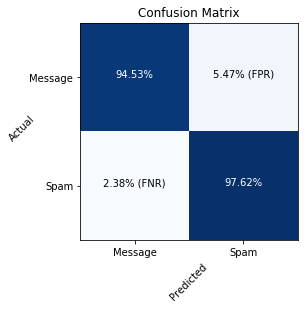

In [167]:
#
# Calculate the features, build the model, predict and show the confusion matrix and the accuracy
#
X_train = np.array([list(features_ver2(content)) for content in train])
X_test = np.array([list(features_ver2(content)) for content in test])

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('Acuracy:', accuracy_score(y_test, y_pred))
plot_confusion_matrix(cm, normalized=True)

## Decision Tree Parameters & Overfitting

Most machine learning algorithms get parameters which control how they behave.
Setting correct values to these parameters is usually very important. 

For instance, deicision tree can get its maximum depth.

In [168]:
def predict_with_tree(X_train, y_train, X_test, max_depth=None):
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    tree.fit(X_train, y_train)
    
    y_pred = tree.predict(X_test)
    y_pred_train = tree.predict(X_train)
    
    return y_pred, y_pred_train

Calculate the accuracy of a model when it is run on the test set and on the train set when using different maximumum tree depths: 1, 11, 21 and 31:

In [169]:
# TODO: Calculate the accuracies (fill )
test_accuracies = []
train_accuracies = []

for i in range(1, 50, 10):
    y_pred, y_train_pred = predict_with_tree(X_train, y_train, X_test, max_depth=i)
    test_accuracies.append(sum(y_pred == y_test) / len(y_test))
    train_accuracies.append(sum(y_train_pred == y_train) / len(y_train_pred))
    print(i, test_accuracies[-1], train_accuracies[-1], flush=True)

1 0.954214559387 0.97125
11 0.961494252874 0.9804
21 0.96245210728 0.9919
31 0.961685823755 0.997225
41 0.960536398467 0.9986


Sometimes it is more convinient to look at the value 1-accuracy which we'll call the error:

In [170]:
test_error = [(1 - test_accuracy) for test_accuracy in test_accuracies]
train_error = [(1 - train_accuracy) for train_accuracy in train_accuracies]

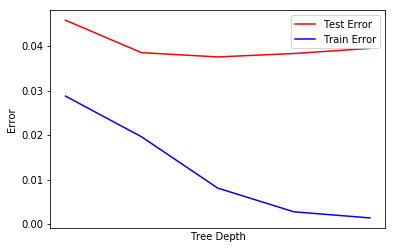

In [171]:
#
# TODO: Create a plot of test & train errors vs. tree depth
#
plt.plot(test_error, 'r', label='Test Error')
plt.plot(train_error, 'b', label='Train Error')
plt.axes().get_xaxis().set_ticks([])
plt.xlabel('Tree Depth')
plt.ylabel('Error')
plt.legend()
plt.show()

We see that while the **training error continued to decrease** as we used more sophisticated trees,
the **error on the test set didn't decrease**. Why?

## Random Forest

In [192]:
from sklearn.ensemble import RandomForestClassifier

# TODO: Write a function predict_with_forest as described below:

def predict_with_forest(X_train, y_train, X_test):
    """The function gets three parameters:
            X_train: training features
            y_train: training labels
            X_test: test set features.
            
        The function uses random forest to train on the training features and labels.
        It then uses the trained forest to predict the label for the test features.
        Then it returns the predicted test labels.
    """
    # TODO: implement
    tree = RandomForestClassifier(random_state=0)
    tree.fit(X_train, y_train)
    return tree.predict(X_test)

Acuracy: 0.966954022989


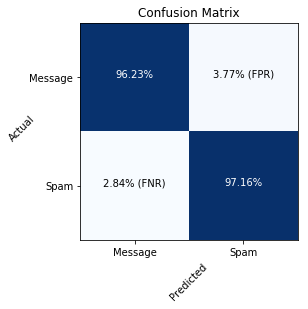

In [115]:
#
# Calculate the features, predict using forest and show the confusion matrix and the accuracy
#
X_train = np.array([list(features_ver2(content)) for content in train])
X_test = np.array([list(features_ver2(content)) for content in test])

y_pred = predict_with_forest(X_train, y_train, X_test)

cm = confusion_matrix(y_test, y_pred)
print('Acuracy:', accuracy_score(y_test, y_pred))
plot_confusion_matrix(cm, normalized=True)

## Manual Boosting

One of the simplest ways to improve our models is to look at the samples the get wrong and think of features that could improve that. This process, when done automatically, is called boosting. Let's do it manually.

In [186]:
#
# Create an array false_positives with indexes of training sample on which 
# our model returns positive predicitons when they are actually negative
#
y_pred_train = predict_with_forest(X_train, y_train, X_train)
false_positives = np.where((y_train != y_pred_train) & y_pred_train)[0]

In [189]:
#
# Print one false positive
#
print(train[false_positives[2]].decode(errors='ignore'))

From bounce-debian-laptop=ktwarwic=speedy.uwaterloo.ca@lists.debian.org  Sun Apr  8 15:50:03 2007
Return-Path: <bounce-debian-laptop=ktwarwic=speedy.uwaterloo.ca@lists.debian.org>
Received: from murphy.debian.org (murphy.debian.org [70.103.162.31])
	by speedy.uwaterloo.ca (8.12.8/8.12.5) with ESMTP id l38Jo00I004616
	for <ktwarwic@speedy.uwaterloo.ca>; Sun, 8 Apr 2007 15:50:00 -0400
Received: from localhost (localhost [127.0.0.1])
	by murphy.debian.org (Postfix) with QMQP
	id 17CFF2E7CE; Sun,  8 Apr 2007 14:49:29 -0500 (CDT)
Old-Return-Path: <www-data@marx.golgotha.net>
X-Spam-Checker-Version: SpamAssassin 3.1.4 (2006-07-26) on murphy.debian.org
X-Spam-Level: **
X-Spam-Status: No, score=2.8 required=4.0 tests=BAYES_60,BLANK_LINES_70_80 
	autolearn=no version=3.1.4
X-Original-To: debian-laptop@lists.debian.org
Received: from mail.golgotha.net (marx.golgotha.net [88.198.36.74])
	by murphy.debian.org (Postfix) with ESMTP id 5DC6E2E7AC
	for <debian-laptop@lists.debian.org>; Sun,  8 Apr 200

In [190]:
#
# Add new features which will prevent the last sample to be detected as positive
#    
def features_ver3(content):
    headers = get_headers(content)

    subj = subject(headers)
    send = sender(headers)
    sender_domain = send.split(b'@')[-1][:-1] if send else b''
    
    yield from subject_features(subj)
    yield from sender_domain_features(sender_domain)
        
    #
    # TODO: add some features
    #
    yield b'nsubscribe' in content
    yield b'ubscribe' in content

Acuracy: 0.981704980843


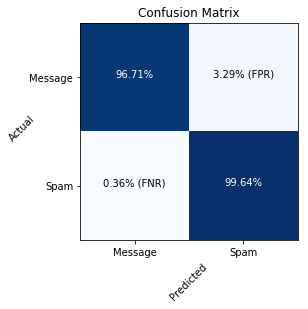

In [194]:
#
# Calculate the features, predict using forest and show the confusion matrix and the accuracy
#
X_train = np.array([list(features_ver3(content)) for content in train])
X_test = np.array([list(features_ver3(content)) for content in test])

y_pred = predict_with_forest(X_train, y_train, X_test)

cm = confusion_matrix(y_test, y_pred)
print('Acuracy:', accuracy_score(y_test, y_pred))
plot_confusion_matrix(cm, normalized=True)